# Installs and Imports

In [7]:
# !pip install pyvista
# !pip install matplotlib

In [1]:
import dolfinx
import ufl
import numpy as np
import json
import itertools
from petsc4py import PETSc
from mpi4py import MPI
from operator import itemgetter
from matplotlib import pyplot as plt
from math import pi, sin, cos

# FEM Code Functions

In [2]:
FEM_FIXEDPARAM_KEYS = ["W", "L", "el_order"]
FEM_OBJS_LIST = ["B", "T", "mesh", "F", "dx", "ds", "u", "v", "J", "I", "Ic", "bcs"]

def create_fem_objs(elem_size, fixed_params):
    
    # Unpack fixed_params:
    W, L, el_order = itemgetter(*FEM_FIXEDPARAM_KEYS)(fixed_params)

    # Compute number of elements along width and length:
    NL, NW = round(L/elem_size), round(W/elem_size)
    
    num_elem = NL*NW*NW
    
    mesh = dolfinx.BoxMesh(MPI.COMM_WORLD,[[0.0,0.0,0.0], [L, W, W]], [NL, NW, NW], dolfinx.cpp.mesh.CellType.tetrahedron)
    V = dolfinx.VectorFunctionSpace(mesh, ("CG", el_order))

    left = lambda x : np.isclose(x[0], 0)
    right = lambda x : np.isclose(x[0], L)

    left_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left)
    right_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, right)

    # Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with two
    marked_facets = np.hstack([left_facets, right_facets])
    marked_values = np.hstack([np.full(len(left_facets), 1, dtype=np.int32), np.full(len(right_facets), 2, dtype=np.int32)])
    sorted_facets = np.argsort(marked_facets)
    facet_tag = dolfinx.MeshTags(mesh, mesh.topology.dim-1, marked_facets[sorted_facets], marked_values[sorted_facets])

    u_bc = dolfinx.Function(V)
    with u_bc.vector.localForm() as loc:
        loc.set(0)

    left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.indices[facet_tag.values==1])
    bcs = [dolfinx.DirichletBC(u_bc, left_dofs)]

    # Compute new body force:
    B = dolfinx.Constant(mesh, (0, 0, 0))
    T = dolfinx.Constant(mesh, (0, 0, 0))

    v = ufl.TestFunction(V)
    u = dolfinx.Function(V)

    # Spatial dimension
    d = len(u)
    # Identity tensor
    I = ufl.variable(ufl.Identity(d))
    # Deformation gradient
    F = ufl.variable(I + ufl.grad(u))
    # Right Cauchy-Green tensor
    C = ufl.variable(F.T * F)
    # Invariants of deformation tensors
    Ic = ufl.variable(ufl.tr(C))
    J  = ufl.variable(ufl.det(F))

    metadata = {"quadrature_degree": 4}
    ds = ufl.Measure('ds', subdomain_data=facet_tag, metadata=metadata)
    dx = ufl.Measure("dx", metadata=metadata)
    fem_params = {key : val for (key, val) in zip(FEM_OBJS_LIST, (B, T, mesh, F, dx, ds, u, v, J, I, Ic, bcs))}
    
    return (fem_params, num_elem)

In [3]:
LOADING_FIXEDPARAM_KEYS = ["nu", "rho", "g", "num_steps"]

MAX_SUBSTEP = 10
SUBSTEP_DIV = 100

# Function which performs loading for a particular set of parameters:
def perform_loading(E, beam_angle, fixed_params, fem_objects):
    
    # Unpack FEM objects:
    B, T, mesh, F, dx, ds, u, v, J, I, Ic, bcs = itemgetter(*FEM_OBJS_LIST)(fem_objects)
    
    # Unpack
    nu, rho, g, num_steps = itemgetter(*LOADING_FIXEDPARAM_KEYS)(fixed_params)
    
    f_step = rho*g/num_steps
    beam_angle *= pi/180
    
    # Compute Lame parameters:
    mu = dolfinx.Constant(mesh, E/(2*(1 + nu)))
    lmbda = dolfinx.Constant(mesh, E*nu/((1 + nu)*(1 - 2*nu)))
    
    # Stored strain energy density (compressible neo-Hookean model)
    psi = (mu / 2) * (Ic - 3) - mu * ufl.ln(J) + (lmbda / 2) * (ufl.ln(J))**2
    # Hyper-elasticity
    P = ufl.diff(psi, F)
        
    # Define form F (we want to find u such that F(u) = 0)
    F = ufl.inner(ufl.grad(v), P)*dx - ufl.inner(v, B)*dx - ufl.inner(v, T)*ds(2) 
    
    # Delete cache of previous models:
    !rm -r /root/.cache/fenics/*
    
    problem = dolfinx.fem.NonlinearProblem(F, u, bcs)
    solver = dolfinx.NewtonSolver(MPI.COMM_WORLD, problem)
    solver.rtol = 1e-3
    solver.atol = 1e-3
    solver.max_it = 10
    
    for i in range(num_steps):
        print(f'Performing load step {i+1}/{num_steps}')
        substep_count = 0
        finished_step = False
        while not finished_step:
            
            # Check if we've gone over maximum number of substeps:
            if substep_count>=MAX_SUBSTEP:
                raise Exception('Exceeded maximum number of sub-steps')
            
            # Update body force on beam:
            B.value[0] = (i+1)*f_step*cos(beam_angle)/(SUBSTEP_DIV*substep_count+1)
            B.value[2] = -(i+1)*f_step*sin(beam_angle)/(SUBSTEP_DIV*substep_count+1)
            
            # Perform step/substep:
            try:
                num_its, converged = solver.solve(u)
                assert(converged)
            except RuntimeError:
                print(f'Warning - Step did not converge. Performing sub-step {substep_count+1}')
                substep_count +=1
                continue 
            
            # If at this point in code, our full or substep has worked - update displacement:
            u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
            
            # If we've performed a substep which has worked, then try perform full-step from this position:
            if substep_count>0:
                print(f'Sub-step performed successfully; now reattempting full step.')
                substep_count=0
            # If we haven't performed a sub-step, just go to next step:
            else:
                finished_step = True

    u_vals = u.compute_point_values().real
    return u_vals

# Mesh Convergence

## Define Sub-Routine

In [4]:
FIXED_PARAMS_MESH = ["W", "L", "nu", "rho", "g", "num_steps"]

def mesh_convergence(num_elem_list, E, beam_angle, fixed_params):
    
    # Extract length and width of beam
    L, W = fixed_params['L'], fixed_params['W']
    
    # Compute beam volume:
    beam_vol = L*W**2
    
    # Initialise list to store results:
    results_dict = {'End Displacement':[], 'Number of Elements':[], 'Element Size':[]}
    
    # Iterate over all mesh elements to explore 
    for i, num_elem in enumerate(num_elem_list):
        
        print(f'Simulating Mesh {i+1}/{len(num_elem_list)} (Number of elements = {num_elem})')
        
        # Compute size of elements:
        elem_size = (beam_vol/num_elem)**(1/3)
        results_dict['Element Size'].append(elem_size)
        
        # First, create 'fixed' parameters of model:
        fem_objects, true_num_elem = create_fem_objs(elem_size, fixed_params)
        results_dict['Number of Elements'].append(true_num_elem)
        
        # Performing loading:
        u_val = perform_loading(E, beam_angle, fixed_params, fem_objects)
        
        # Get displacement at end of beam:
        idx_2_get = np.isclose(fem_objects['mesh'].geometry.x, [fixed_params['L'], fixed_params['W'], fixed_params['W']])
        idx_2_get = np.where(np.all(idx_2_get, axis=1))
        disp_vals = np.sum(u_val**2, axis=1)**(1/2)
        results_dict['End Displacement'].append(disp_vals[idx_2_get].item())
        print(f'End disp = {disp_vals[idx_2_get]}')
    
    # Also store fixed parameters with results:
    results_dict['E'] = E
    results_dict['Beam Angle'] = beam_angle
    results_dict.update(fixed_params)
    
    return results_dict

## Compute Mesh Convergence Points

In [ ]:
# Material constants:
nu = 0.33 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2

# Beam dimensions:
W = 40 # in mm
L = 90 # in mm

# FEM parameters:
el_order = 2
num_steps = 10

# Store parameters in dictionary:
fixed_params = {"nu":nu, "rho":rho, "g":g, "el_order":el_order, "L":L, "W":W, "num_steps":num_steps}

# Define stiffness and beam angle to perform convergence study for:
E = 10
beam_angle = 90

# Define number of elements to check:
num_elem_list = [100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000] # 
    
# Create results dictionary:
convergence_results = mesh_convergence(num_elem_list, E, beam_angle, fixed_params)

# Save dictionary to JSON file:
save_name = "nonlinear_convergence.json"
with open('./'+save_name, 'w') as f:
    json.dump(convergence_results, f, indent=4)

Simulating Mesh 1/11 (Number of elements = 100)
Performing load step 1/10
Performing load step 2/10
Performing load step 3/10
Performing load step 4/10
Performing load step 5/10
Performing load step 6/10
Performing load step 7/10
Performing load step 8/10
Performing load step 9/10
Performing load step 10/10
End disp = [68.84]
Simulating Mesh 2/11 (Number of elements = 250)
Performing load step 1/10
Performing load step 2/10
Performing load step 3/10
Performing load step 4/10
Performing load step 5/10
Performing load step 6/10
Performing load step 7/10
Performing load step 8/10
Performing load step 9/10
Performing load step 10/10
End disp = [69.07]
Simulating Mesh 3/11 (Number of elements = 500)
Performing load step 1/10
Performing load step 2/10
Performing load step 3/10
Performing load step 4/10
Performing load step 5/10
Performing load step 6/10
Performing load step 7/10
Performing load step 8/10
Performing load step 9/10
Performing load step 10/10
End disp = [69.19]
Simulating Mesh 

## Plot Mesh Convergence

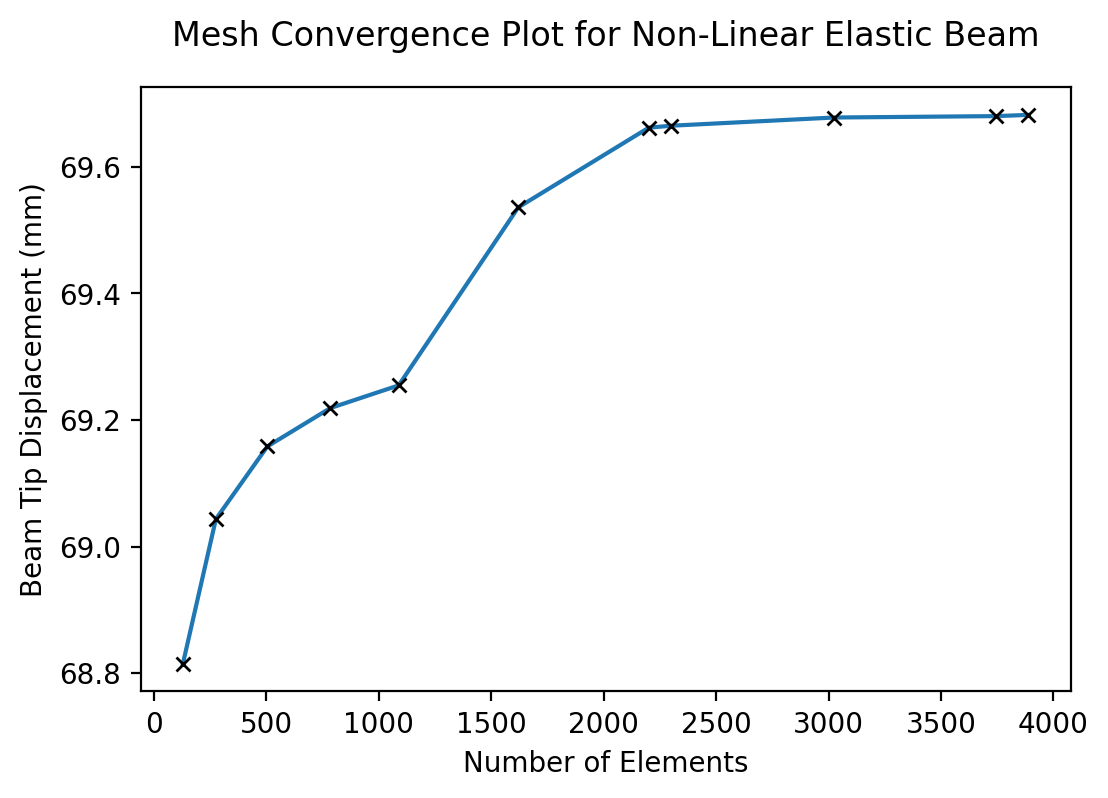

In [1]:
# Mesh convergence plot:
import json
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi'] = 200

with open('./nonlinear_convergence.json', 'r') as f:
    convergence_results = json.load(f)
fig, ax = plt.subplots()
plt.plot(convergence_results['Number of Elements'], convergence_results['End Displacement'])
plt.title('Mesh Convergence Plot for Non-Linear Elastic Beam', pad=15)
ax.set_xlabel('Number of Elements')
ax.set_ylabel('Beam Tip Displacement (mm)')
fig.patch.set_facecolor('white')
plt.plot(convergence_results['Number of Elements'], convergence_results['End Displacement'], 'x', color='black', markersize=5)
plt.show()

Appears that 2500 elements is more than enough to achieve convergence in both linear and non-linear case - compute corresponding element size:

# Generate Data

## Define Sub-Routines

In [4]:
# Computes all possible parameter combinations: 
def create_param_combos(param_list):
    keys = param_list.keys()
    param_combos = []
    for bundle in itertools.product(*param_list.values()):
        param_dict = dict(zip(keys, bundle))
        param_combos.append(param_dict)
    return param_combos

In [5]:
# Computes all end displacements for all provided parameter values:
def create_data(params_dict, num_elem, fixed_params): 
    
    # Extract length and width of beam
    L, W = fixed_params['L'], fixed_params['W']
    
    # Compute beam volume:
    beam_vol = L*W**2
    
    # Compute size of elements:
    elem_size = (beam_vol/num_elem)**(1/3)
    
    # Generate all possible combinations of training data parameters:
    param_combos = create_param_combos(params_dict)
    results_dict = {'E':[], 'Beam Angle':[], 'End Displacement':[]}
    for i, params in enumerate(param_combos):
        
        print(f"Computing data point {i+1}/{len(param_combos)}: E={params['E']}, Angle={params['angle']}")
        
        # Store inputs:
        results_dict['E'].append(params['E'])            
        results_dict['Beam Angle'].append(params['angle']) 
        
        # Generate FEM objects:
        fem_objects, true_num_elem = create_fem_objs(elem_size, fixed_params)
        
        # Workout index of node to get displacement from:
        idx_2_get = np.isclose(fem_objects['mesh'].geometry.x, [fixed_params['L'], fixed_params['W'], fixed_params['W']])
        idx_2_get = np.where(np.all(idx_2_get, axis=1))
    
        
        # Perform simulation:
        u_val = perform_loading(params['E'], params['angle'], fixed_params, fem_objects)
        
        # Compute end displacement:
        disp = np.sum(u_val**2, axis=1)**(1/2)               
        results_dict['End Displacement'].append(disp[idx_2_get].item())
                                
    # Store fixed parameters and element size in this dictionary as well:
    results_dict["Element size"] = elem_size
    results_dict["Number of Elements"] = true_num_elem
    results_dict.update(fixed_params)
    
    return results_dict

## Define Fixed Parameters

In [6]:
nu = 0.33 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2
W = 40 # in mm
L = 90 # in mm
el_order = 2
num_steps = 10
# Store parameters in dictionary:
fixed_params = {"nu":nu, "rho":rho, "g":g, "el_order":el_order, "L":L, "W":W, "num_steps":num_steps}

# Define number of elements:
num_elem = 2500

## Create Training Data

In [ ]:
# First create training data:
num_pts = 10
min_E, max_E = 10, 40
min_ang, max_ang = 0, 180
train_params = {'E': np.linspace(min_E, max_E, num_pts),
                'angle': np.linspace(min_ang, max_ang, num_pts)}

training_dict = create_data(train_params, num_elem, fixed_params)

# Save dictionary to JSON file:
save_name = "nonlinear_train.json"
with open('./'+save_name, 'w') as f:
    json.dump(training_dict, f, indent=4)

## Create Test Data

In [8]:
# Next create test data:
delta_E = (max_E-min_E)/(num_pts-1)
delta_ang = (max_ang-min_ang)/(num_pts-1)
E_test = [E for E in np.linspace(min_E+0.5*delta_E, max_E-0.5*delta_E, num_pts-1)]
angle_test = [angle for angle in np.linspace(min_ang+0.5*delta_ang, max_ang-0.5*delta_ang, num_pts-1)]
test_params = {"E": E_test, "angle": angle_test}

test_dict = create_data(test_params, num_elem, fixed_params)

# Save dictionary to JSON file:
save_name = "nonlinear_test.json"
with open('./'+save_name, 'w') as f:
    json.dump(test_dict, f, indent=4)

Computing data point 1/81: E=11.666666666666666, Angle=10.0
Performing load step 1/10
Performing load step 2/10
Performing load step 3/10
Performing load step 4/10
Performing load step 5/10
Performing load step 6/10
Performing load step 7/10
Performing load step 8/10
Performing load step 9/10
Performing load step 10/10
Computing data point 2/81: E=11.666666666666666, Angle=30.0
Performing load step 1/10
Performing load step 2/10
Performing load step 3/10
Performing load step 4/10
Performing load step 5/10
Performing load step 6/10
Performing load step 7/10
Performing load step 8/10
Performing load step 9/10
Performing load step 10/10
Computing data point 3/81: E=11.666666666666666, Angle=50.0
Performing load step 1/10
Performing load step 2/10
Performing load step 3/10
Performing load step 4/10
Performing load step 5/10
Performing load step 6/10
Performing load step 7/10
Performing load step 8/10
Performing load step 9/10
Performing load step 10/10
Computing data point 4/81: E=11.66666

# Plot Data

## Plotting Function

In [2]:
# Let's plot the training and test data:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

mpl.rcParams['figure.dpi'] = 200

def plot_data(data, grid_shape, num_levels, E_lims=None, angle_lims=None, y_lims=None, title=None):

    angle, E, y = np.array(data['Beam Angle']), np.array(data['E']), np.array(data['End Displacement'])
    
    levels = np.linspace(y_lims[0], y_lims[1], num_levels)
    
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(E.reshape(grid_shape), angle.reshape(grid_shape), y.reshape(grid_shape), 
                              levels=levels, cmap=cm.coolwarm)
    
    ticks = np.array(range(y_lims[0], y_lims[1]+1, 20))
    cbar = fig.colorbar(contour_fig, ticks=ticks)
    cbar.set_label('Beam Tip Displacement (mm)', rotation=270, labelpad=15)
    ax.set_xlabel("Young's Modulus (kPa)")
    ax.set_ylabel('Beam Angle (degrees)')
    ax.set_xlim(E_lims)
    ax.set_ylim(angle_lims)
    plt.title(title, pad=15)
    plt.plot(E, angle, 'x', color='black', markersize=3)
    fig.patch.set_facecolor('white')
    plt.show()

## Plot Training Data

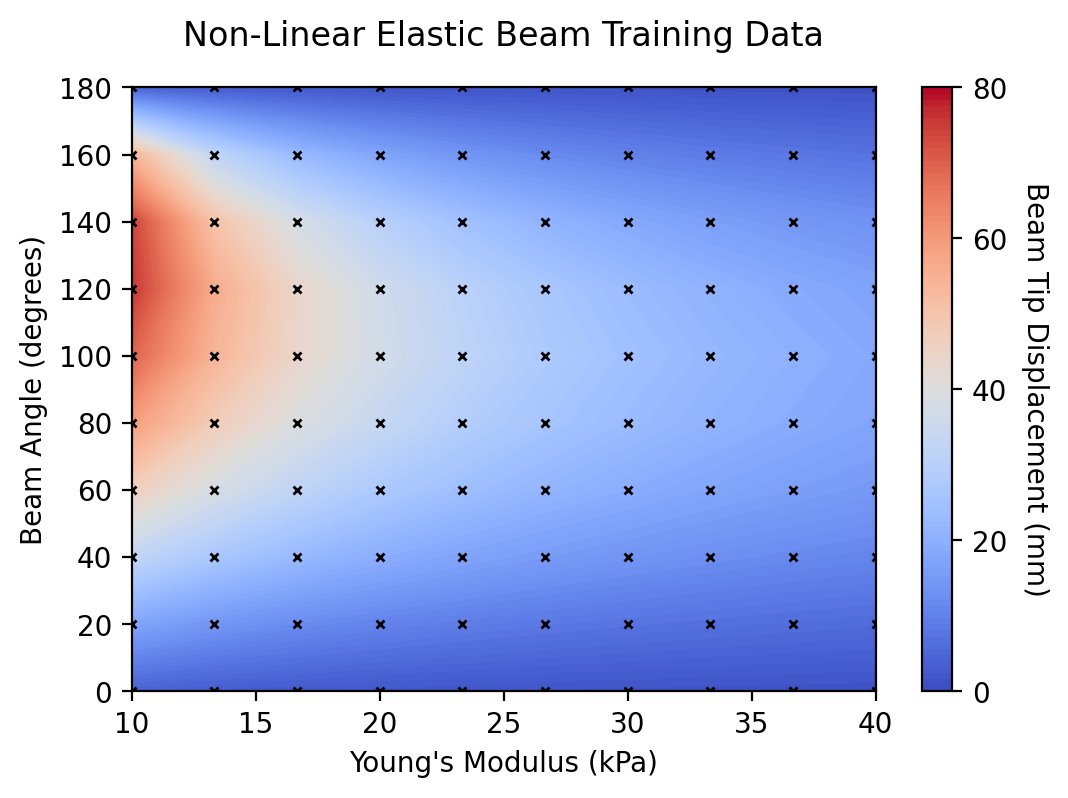

In [4]:
with open('nonlinear_train.json', 'r') as f:
    training_dict = json.load(f)

y_lims = [0, 80]
E_lims = [10, 40]
angle_lims = [0, 180]
grid_shape = (10, 10)
num_levels = 100
title = "Non-Linear Elastic Beam Training Data"
plot_data(training_dict, grid_shape, num_levels, E_lims, angle_lims, y_lims, title)

## Plot Test Data

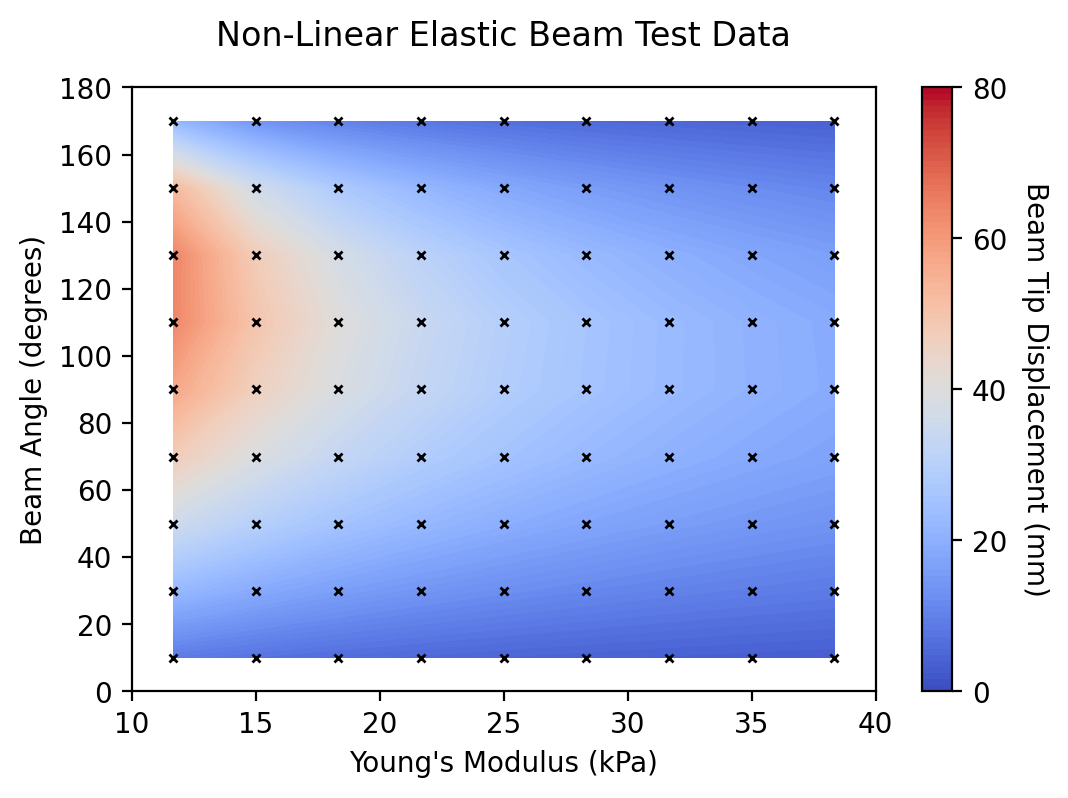

In [6]:
with open('nonlinear_test.json', 'r') as f:
    test_dict = json.load(f)

y_lims = [0, 80]
E_lims = [10, 40]
angle_lims = [0, 180]
grid_shape = (9, 9)
num_levels = 100
title = "Non-Linear Elastic Beam Test Data"
plot_data(test_dict, grid_shape, num_levels, E_lims, angle_lims, y_lims, title)